<a href="https://colab.research.google.com/github/Indian-otaku/Introduction_To_PyTorch/blob/main/torchvision3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import all necessary modules

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST

torch.manual_seed(42)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
train_data = FashionMNIST(root='data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          target_transform=None,
                          download=True)
test_data = FashionMNIST(root='data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         target_transform=None,
                         download=True)
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
type(train_data)

torchvision.datasets.mnist.FashionMNIST

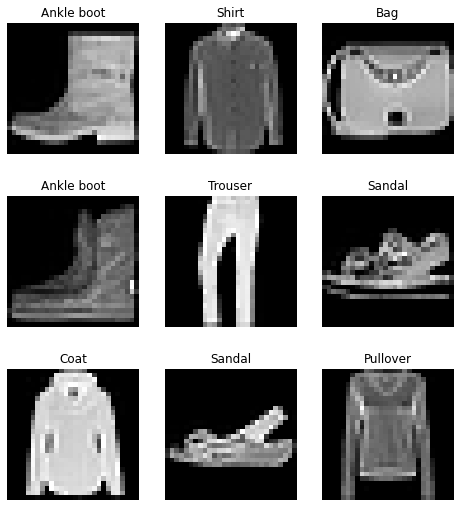

In [ ]:
row = 3
col = 3

plt.figure(figsize=(8,9))
for i in range(1, row*col+1):
    rand_index = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[rand_index]
    plt.subplot(row, col, i)
    plt.imshow(image.squeeze(),
               cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

In [ ]:
BATCH_SIZE = 32

train_data_loader = DataLoader(dataset=train_data,
                               shuffle=True,
                               batch_size=BATCH_SIZE)
test_data_loader = DataLoader(dataset=test_data,
                              shuffle=False,
                              batch_size=BATCH_SIZE)
train_data_loader

In [ ]:
train_data_loader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
class FMNISTModel(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=n_inputs,
                      out_features=n_hidden,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Linear(in_features=n_hidden,
                      out_features=n_outputs,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model1 = FMNISTModel(n_inputs=28*28,
                     n_hidden=10,
                     n_outputs=len(train_data_loader.dataset.classes)).to(device)
model1

FMNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [ ]:
def accuracy_fn(y_pred, y_true):
    return (y_pred==y_true).sum().item() / len(y_pred)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)



# Not gonna use this 
def training(model:torch.nn.Module,
             data_loader:torch.utils.data.DataLoader,
             epochs:int,
             loss_fn:torch.nn.Module,
             accuracy_fn,
             optimizer:torch.optim.SGD,
             device:torch.device = device):
    
    start_time = default_timer()

    model = model.to(device)

    model.train()
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        train_acc = 0
        for batch, (X_train, y_train) in enumerate(data_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            train_loss += loss

            acc = accuracy_fn(y_pred.argmax(dim=1), y_train)
            train_acc += acc

            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)
        print(f"Train loss: {train_loss:.3f} accuracy: {train_acc*100:.3f}")
    
    end_time = default_timer()

    total_time = end_time - start_time

    return {"Model name": model.__class__.__name__,
            "Average accuracy": train_acc,
            "Average loss": train_acc,
            "Total time taken": total_time}



In [ ]:
def training_step(model:torch.nn.Module,
             data_loader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             accuracy_fn,
             optimizer:torch.optim.Optimizer,
             device:torch.device = device):
    
    model = model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0

    for batch, (X_train, y_train) in enumerate(data_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        train_loss += loss
        acc = accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y_train)
        train_acc += acc
        model.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} accuracy: {train_acc*100:.3f}%")


def testing_step(model:torch.nn.Module,
             data_loader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             accuracy_fn,
             device:torch.device = device):
    
    model = model.to(device)
    model.eval()

    test_loss = 0
    test_acc = 0

    with torch.inference_mode():    
        for X_test, y_test in data_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(X_test)
            loss = loss_fn(y_pred, y_test)
            test_loss += loss
            acc = accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y_test)
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} accuracy: {test_acc*100:.3f}%\n")


def accuracy_fn(y_pred, y_true):
    return (y_pred==y_true).sum().item() / len(y_pred)

In [ ]:
from timeit import default_timer
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 3
start_timer = default_timer()

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)

for epoch in tqdm(range(epochs)):
    print(f"-----------------------------------------------------Epoch {epoch}---------------------------------------------------------")
    training_step(model=model1,
                  data_loader=train_data_loader,
                  loss_fn=loss_fn,
                  accuracy_fn=accuracy_fn,
                  optimizer=optimizer,
                  device=device)
    testing_step(model=model1,
                 data_loader=test_data_loader,
                 loss_fn=loss_fn,
                 accuracy_fn=accuracy_fn,
                 device=device)
    
end_timer = default_timer()

total_time = end_timer - start_timer
print(f"Total time taken : {total_time} on device {device}")

  0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------Epoch 0---------------------------------------------------------
Train loss: 0.89563 accuracy: 68.658%
Test loss: 0.71564 accuracy: 73.762%

-----------------------------------------------------Epoch 1---------------------------------------------------------
Train loss: 0.68536 accuracy: 74.895%
Test loss: 0.68568 accuracy: 74.720%

-----------------------------------------------------Epoch 2---------------------------------------------------------
Train loss: 0.52485 accuracy: 81.180%
Test loss: 0.51050 accuracy: 82.099%

Total time taken : 37.659530503999974 on device cuda
